### TODO

- Find the right way to turn the solution into integers

In [1]:
from random import randint
import sys

import numpy as np
import scipy.optimize as optimize
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%xmode plain

def init_simulation(num_nodes, 
                    num_days, 
                    icu_capacities = None, 
                    transport_capacities = None, 
                    ini_path = None, 
                    demand_min = 80, 
                    demand_max = 90,
                    icu_min = 10,
                    icu_max = 300,
                    transport_min = 20,
                    transport_max = 30):
    if ini_path:
        print("you can also upload an .ini file")
        raise NotImplemented
    else:
        demand = []
        for node in range(num_nodes):
            demand.append(list(np.random.randint(demand_min, demand_max, size = num_days)))
        
        icu_capacities = icu_capacities if icu_capacities else list(np.random.randint(icu_min, 
                                                                                      icu_max, 
                                                                                      size = num_nodes))
        transport_capacities = transport_capacities if transport_capacities else list(np.random.randint(transport_min, 
                                                                                                        transport_max, 
                                                                                                        size = num_nodes)) 
    return icu_capacities, transport_capacities, demand


def calculate_outgoing(array,day,node):
    return sum(array[day][node])


def calculate_incoming(array,day,node):
    total_outgoing = 0
    for n in range(num_nodes):
        total_outgoing = total_outgoing + array[day][n][node]
    return total_outgoing


def demand_day_node_raw(node_capacity, demand_day, left_day, received_day, demand_previous_days, left_previous_days, received_previous_days):
    return demand_day - left_day + received_day+ min(demand_previous_days-left_previous_days+received_previous_days, node_capacity)


def demand_day_node(movements,day,node):
    movements_res = np.reshape(movements,(num_days,num_nodes,num_nodes))
    total_received_patients = 0
    total_outbound_patients = 0
    accumulated_demand = 0
    for d in range(day):
        total_received_patients = total_received_patients + calculate_incoming(movements_res,d,node)
        total_outbound_patients = total_outbound_patients + calculate_outgoing(movements_res,d,node)
    accumulated_demand = sum(demands[node][:day])
    
    demand = max(0, demand_day_node_raw(node_capacities[node],demands[node][day], 
                                        calculate_outgoing(movements_res,day,node), calculate_incoming(movements_res,day,node),
                                        accumulated_demand, total_outbound_patients, total_received_patients                
                ))
    return demand


def calc_total_deaths(movements):
    total = 0
    movements_res = np.reshape(movements,(num_days,num_nodes,num_nodes))
    for node in range(num_nodes):
        for day in range(num_days):
            deaths_not_attended = max(0, demand_day_node(movements,day,node) - node_capacities[node])
            deaths_transport = prob_death_transport*movements_res[day].sum()
            total = total + deaths_not_attended + deaths_transport
    return total


def outgoing_list(movements):
    movements_res = np.reshape(movements,(num_days,num_nodes,num_nodes))
    outgoing_list = list()
    for day in range(num_days):
        for node in range(num_nodes):
            outgoing_list.append(calculate_outgoing(movements_res,day,node))
    return outgoing_list

def generate_bounds():
    outgoing_list = list()
    for day in range(num_days):
        for outgoing_node in range(num_nodes):
            for incoming_node in range(num_nodes):
                outgoing_list.append((0,transport_capacities[outgoing_node]))
    return outgoing_list

def f_cons(node_id, day):
    return lambda x: transport_capacities[node_id] - calculate_outgoing(np.reshape(x,(num_days,num_nodes,num_nodes)),day ,node_id)


def split_n(num, num_nodes):
    #TODO this function is not truly random
    pieces = []
    for idx in range(num_nodes-1):
        pieces.append(randint(1,num-sum(pieces)-num_nodes+idx))

    pieces.append(num-sum(pieces))
    return pieces

Exception reporting mode: Plain


In [113]:
prob_death_transport = 0
num_days = 5
num_nodes = 4
node_capacities, transport_capacities, demands = init_simulation(num_nodes, 
                                                                 num_days, 
                                                                 icu_capacities=[6000, 20, 100, 1000],
                                                                 transport_capacities=[0, 150, 150, 0], 
                                                                 demand_min = 50, demand_max = 250)
print(f"""Randomly generated
{num_days} days, {num_nodes} hospitals
ICU capacities of hospitals: {node_capacities}
Daily transport capacities: {transport_capacities}, 
Daily simulated demand (from uniform distrution): 
{demands}""")

Randomly generated
5 days, 4 hospitals
ICU capacities of hospitals: [6000, 20, 100, 1000]
Daily transport capacities: [0, 150, 150, 0], 
Daily simulated demand (from uniform distrution): 
[[166, 121, 129, 72, 162], [202, 67, 244, 192, 123], [221, 102, 101, 84, 194], [215, 220, 70, 212, 245]]


In [114]:
#define constraints
cons = []
for node in range(num_nodes):
    for day in range(num_days):
        cons.append({'type': 'ineq', 'fun': f_cons(node,day)})

        
#no movement matrix, the base for generating random ones and one of the ones to test as init matrix 
no_movement = np.array([[[0]*num_nodes]*num_nodes]*num_days)

In [161]:
np.random.choice([0,1])

1

In [163]:
def random_init(knockdown_days = False, movement_intensity = 1, random_intensity = False, prior_matrix = np.array([])): 
    random_movement = prior_matrix.copy() if prior_matrix.any() else no_movement.copy()
    #if knockdown days is active, behave like a dropdown NN layer and drop half of the days movements
    active_days = np.random.choice([1,0], size=num_days) if knockdown_days else [1]*num_days
    for day in range(num_days):
        if active_days[day]:
            for node_x in range(num_nodes):
                movement_intensity = np.random.uniform() if random_intensity else movement_intensity
                #splits a number in a list of numbers pseudo randomly
                split_nodes = split_n(max(num_nodes+1, 
                                          np.ceil(transport_capacities[node_x]*movement_intensity)), 
                                      num_nodes)
                for node_y in range(num_nodes):
                    if node_x != node_y: 
                        if np.random.choice([0,1]): #allow numbers to decrease too
                            random_movement[day, node_x, node_y] += split_nodes[node_y]
                        else: 
                            random_movement[day, node_x, node_y] -= split_nodes[node_y]
                            random_movement[day, node_x, node_y] = max(0, random_movement[day, node_x, node_y])
                    
    return random_movement

### The main loop that generates random init matrices

In [169]:
%%time

#parameters to minimize
min_deaths = sys.maxsize
best_result = None
result_matrix = None
#iterate through low to high intensity movement simulation
steps = []
knockdown = True
win_init_matrix = no_movement.copy()
iterations = 500
movement_intensity = 0.5
miss = 0
for i in range(iterations):
    print(f"i:{i} intensity: {movement_intensity:.2f} knockdown: {knockdown} ", end="")
    if movement_intensity < 0.1 or miss >= 25:
        miss = 0
        print("going into full evolution", end="")
        movement_intensity = 1
        knockdown = False
        
    movement = random_init(knockdown, movement_intensity, prior_matrix=win_init_matrix)
    bounds_movement = generate_bounds()
    result = optimize.minimize(calc_total_deaths, 
                               movement, 
                               method='SLSQP', 
                               constraints=cons, 
                               bounds=bounds_movement)

    current_deaths = calc_total_deaths(np.rint(result.x))
    print(f"Result:{current_deaths:.0f}", end="")
    steps.append([movement_intensity, knockdown, current_deaths])
    if min_deaths >= current_deaths: 
        knockdown = True
        miss = 0
        movement_intensity *= 0.9
        movement_intensity = min(0.5, movement_intensity)
        print(" <--best!", end="")
        min_deaths = int(current_deaths)
        best_result = result
        result_matrix = np.reshape(np.rint(result.x),(num_days,num_nodes,num_nodes))
        win_init_matrix = movement
    else:
        movement_intensity = min(1, movement_intensity*1.05)
        miss += 1

    print("")
        
print("\nDone")

i:0 intensity: 0.50 knockdown: True Result:117 <--best!
i:1 intensity: 0.45 knockdown: True Result:167
i:2 intensity: 0.47 knockdown: True Result:115 <--best!
i:3 intensity: 0.43 knockdown: True Result:117
i:4 intensity: 0.45 knockdown: True Result:116
i:5 intensity: 0.47 knockdown: True Result:119
i:6 intensity: 0.49 knockdown: True Result:119
i:7 intensity: 0.52 knockdown: True Result:117
i:8 intensity: 0.54 knockdown: True Result:117
i:9 intensity: 0.57 knockdown: True Result:118
i:10 intensity: 0.60 knockdown: True Result:115 <--best!
i:11 intensity: 0.50 knockdown: True Result:117
i:12 intensity: 0.53 knockdown: True Result:117
i:13 intensity: 0.55 knockdown: True Result:168
i:14 intensity: 0.58 knockdown: True Result:169
i:15 intensity: 0.61 knockdown: True Result:168
i:16 intensity: 0.64 knockdown: True Result:118
i:17 intensity: 0.67 knockdown: True Result:169
i:18 intensity: 0.70 knockdown: True Result:119
i:19 intensity: 0.74 knockdown: True Result:117
i:20 intensity: 0.78 kn

i:165 intensity: 1.00 knockdown: False Result:116
i:166 intensity: 1.00 knockdown: False Result:167
i:167 intensity: 1.00 knockdown: False Result:118
i:168 intensity: 1.00 knockdown: False Result:168
i:169 intensity: 1.00 knockdown: False Result:168
i:170 intensity: 1.00 knockdown: False Result:116
i:171 intensity: 1.00 knockdown: False Result:168
i:172 intensity: 1.00 knockdown: False Result:118
i:173 intensity: 1.00 knockdown: False Result:168
i:174 intensity: 1.00 knockdown: False Result:118
i:175 intensity: 1.00 knockdown: False Result:116
i:176 intensity: 1.00 knockdown: False Result:168
i:177 intensity: 1.00 knockdown: False Result:115 <--best!
i:178 intensity: 0.50 knockdown: True Result:168
i:179 intensity: 0.53 knockdown: True Result:116
i:180 intensity: 0.55 knockdown: True Result:168
i:181 intensity: 0.58 knockdown: True Result:168
i:182 intensity: 0.61 knockdown: True Result:168
i:183 intensity: 0.64 knockdown: True Result:118
i:184 intensity: 0.67 knockdown: True Result:16

i:328 intensity: 1.00 knockdown: False Result:168
i:329 intensity: 1.00 knockdown: False Result:170
i:330 intensity: 1.00 knockdown: False Result:117
i:331 intensity: 1.00 knockdown: False Result:117
i:332 intensity: 1.00 knockdown: False Result:168
i:333 intensity: 1.00 knockdown: False Result:118
i:334 intensity: 1.00 knockdown: False Result:117
i:335 intensity: 1.00 knockdown: False Result:168
i:336 intensity: 1.00 knockdown: False Result:117
i:337 intensity: 1.00 knockdown: False Result:169
i:338 intensity: 1.00 knockdown: False Result:118
i:339 intensity: 1.00 knockdown: False Result:168
i:340 intensity: 1.00 knockdown: False Result:168
i:341 intensity: 1.00 knockdown: False Result:117
i:342 intensity: 1.00 knockdown: False going into full evolutionResult:116
i:343 intensity: 1.00 knockdown: False Result:168
i:344 intensity: 1.00 knockdown: False Result:117
i:345 intensity: 1.00 knockdown: False Result:169
i:346 intensity: 1.00 knockdown: False Result:117
i:347 intensity: 1.00 kno

i:489 intensity: 1.00 knockdown: False Result:119
i:490 intensity: 1.00 knockdown: False Result:117
i:491 intensity: 1.00 knockdown: False Result:118
i:492 intensity: 1.00 knockdown: False Result:117
i:493 intensity: 1.00 knockdown: False Result:168
i:494 intensity: 1.00 knockdown: False Result:168
i:495 intensity: 1.00 knockdown: False going into full evolutionResult:116
i:496 intensity: 1.00 knockdown: False Result:118
i:497 intensity: 1.00 knockdown: False Result:117
i:498 intensity: 1.00 knockdown: False Result:168
i:499 intensity: 1.00 knockdown: False Result:117

Done
CPU times: user 8min 19s, sys: 4.88 s, total: 8min 24s
Wall time: 8min 17s


### These are the deaths that we get with inaction

In [172]:
calc_total_deaths(no_movement)

1410

### This is the best result found

In [173]:
min_deaths

114

### This the movement matrix

In [171]:
result_matrix

array([[[  0.,   0.,   0.,   0.],
        [124.,   0.,  12.,  15.],
        [150.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.]],

       [[  0.,   0.,   0.,   0.],
        [132.,   0.,  17.,   1.],
        [150.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.]],

       [[  0.,   0.,   0.,   0.],
        [146.,   0.,   3.,   1.],
        [105.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.]],

       [[  0.,   0.,   0.,   0.],
        [135.,   0.,  15.,   1.],
        [116.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.]],

       [[  0.,   0.,   0.,   0.],
        [133.,   0.,  13.,   3.],
        [137.,   3.,   0.,   1.],
        [  0.,   0.,   0.,   0.]]])

In [180]:
df = pd.DataFrame(steps)
df.columns = ["movement_intensity", "knockdown", "result"]

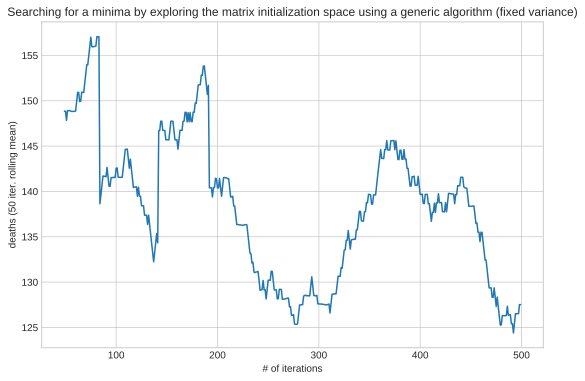

In [181]:
df.result.rolling(50).mean().plot(figsize=(9, 6), title="Searching for a minima by exploring the matrix initialization space using a generic algorithm (fixed variance)")
plt.xlabel("# of iterations")
plt.ylabel("deaths (50 iter. rolling mean)");

In [174]:
for node in range(num_nodes):
    for day in range(num_days):
        print(f'Node: {node}, Day: {day}, Demand: {demand_day_node(np.rint(result.x),day,node)}')

Node: 0, Day: 0, Demand: 436.0
Node: 0, Day: 1, Demand: 805.0
Node: 0, Day: 2, Demand: 1188.0
Node: 0, Day: 3, Demand: 1514.0
Node: 0, Day: 4, Demand: 1963.0
Node: 1, Day: 0, Demand: 52.0
Node: 1, Day: 1, Demand: 0
Node: 1, Day: 2, Demand: 63.0
Node: 1, Day: 3, Demand: 62.0
Node: 1, Day: 4, Demand: 4.0
Node: 2, Day: 0, Demand: 84.0
Node: 2, Day: 1, Demand: 85.0
Node: 2, Day: 2, Demand: 82.0
Node: 2, Day: 3, Demand: 45.0
Node: 2, Day: 4, Demand: 91.0
Node: 3, Day: 0, Demand: 232.0
Node: 3, Day: 1, Demand: 455.0
Node: 3, Day: 2, Demand: 525.0
Node: 3, Day: 3, Demand: 754.0
Node: 3, Day: 4, Demand: 999.0
